In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
#from scipy import ndimage, misc
from cupyx.scipy import ndimage
from skimage.morphology import skeletonize
import sklearn
from sklearn import linear_model
from sklearn import model_selection 
import cv2
import tifffile
import cupy as cp
import matplotlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model

import gc


In [5]:
pattern_dim = 40
threshold = 1/16

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000), np.uint8)

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

im, centroids = generate_pattern(pattern_dim, threshold, 3)

In [15]:
def extract_features(im, sigma):
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    im_8=np.uint8(im)
    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    im_blur = ndimage.gaussian_filter(cp.array(im), sigma=sigma, mode='constant',cval=0)
    
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)
    
    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
    
    feats = []
    #im_lap = ndimage.gaussian_laplace(im, sigma=sigma, mode='reflect')
    for jj in range(np.shape(contours)[0]):            
        im_zer = np.zeros( (im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)
        #number_mat[ii,jj]=number

        density=cp.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad=cp.nanmean(im_sobel[obj[:,0],obj[:,1]])
        #lap=np.nanmean(im_lap[obj[:,0],obj[:,1]])

        feats.append([density.get(), grad.get()])

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    return np.array(feats)

In [16]:
feats = extract_features(im, 400)

(array([ 9.,  6., 19., 14.,  9.,  9.,  6.,  7.,  4.,  3.]),
 array([ 3544.90770181,  4782.86672651,  6020.82575121,  7258.78477591,
         8496.74380061,  9734.70282531, 10972.66185001, 12210.6208747 ,
        13448.5798994 , 14686.5389241 , 15924.4979488 ]),
 <BarContainer object of 10 artists>)

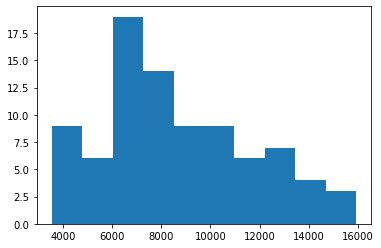

In [17]:
plt.hist(feats[:, 0])

(array([11., 17., 25., 18., 10.,  3.,  1.,  0.,  0.,  1.]),
 array([  0.        ,  37.16886299,  74.33772598, 111.50658897,
        148.67545196, 185.84431495, 223.01317794, 260.18204093,
        297.35090392, 334.51976691, 371.68862989]),
 <BarContainer object of 10 artists>)

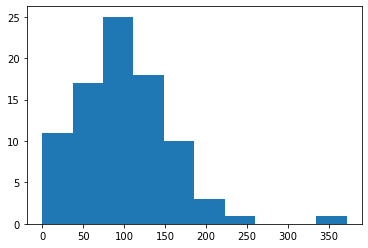

In [18]:
plt.hist(feats[:, 1])

In [46]:
def cp_extract_features(im, sigma):
    im_8=np.uint8(im)
    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    centroid=np.zeros([np.shape(contours)[0],2])
    feats=np.zeros([np.shape(contours)[0],2])
    gc.collect()
    im_blur = ndimage.gaussian_filter(cp.array(im), sigma=sigma, mode='constant',cval=0)
    im_blur_norm=im_blur*sigma*np.sqrt(np.pi)
    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
        #im_lap = ndimage.laplace(im_blur_norm, mode='reflect')
    for jj in range(np.shape(contours)[0]):
        gc.collect()
        im_zer = np.zeros( (im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)
        density=cp.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad=cp.nanmean(im_sobel[obj[:,0],obj[:,1]])
        feats[jj]=np.array([grad.get(), density.get()])
            #lap[ii,jj]=np.nanmean(im_lap[obj[:,0],obj[:,1]])
            # find centroid
        M = cv2.moments(contours[jj])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid[jj]=np.array([cX,cY])
    return feats, centroid

In [25]:
def generate_window(window_size, p, local_radius):
    random_pattern = np.random.rand(window_size, window_size)
    binary_pattern = np.where(random_pattern < p, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25+local_radius
    pattern_dim_scaled = window_size*200+25+2*local_radius
    
    centroids = []
    im = np.zeros((pattern_dim_scaled, pattern_dim_scaled))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

In [26]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]

#svc = SVR(kernel='linear').fit(rxSubScale, ry.ravel())
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

In [27]:
window = 5
p = 0.5
im, centroids = generate_window(window, p, 1000)
feats400 = extract_features(im, 400)
feats800 = extract_features(im, 800)

(array([3., 0., 1., 1., 0., 0., 0., 1., 3., 3.]),
 array([0.23697301, 0.25535008, 0.27372715, 0.29210423, 0.3104813 ,
        0.32885837, 0.34723544, 0.36561251, 0.38398958, 0.40236665,
        0.42074373]),
 <BarContainer object of 10 artists>)

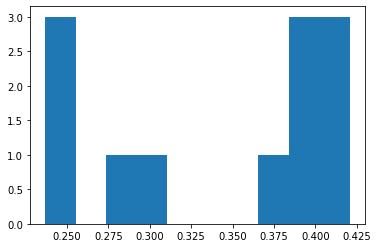

In [31]:
plt.hist(feats400[:, 1])

(array([117., 174., 142.,  73.,  34.,  14.,   6.,   3.,   1.,   4.]),
 array([  8.70546594,  31.42780747,  54.150149  ,  76.87249053,
         99.59483206, 122.3171736 , 145.03951513, 167.76185666,
        190.48419819, 213.20653972, 235.92888125]),
 <BarContainer object of 10 artists>)

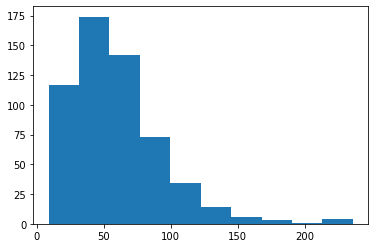

In [32]:
plt.hist(rX.grad_400.values)

# Why was contour needed? to be figured out later

In [2]:
matplotlib.rcParams['figure.figsize'] = [8,8]

In [23]:
pattern_dim = 40
threshold = 1/16

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids
    


In [24]:
im, centroids = generate_pattern(40, 1/16, 3)

In [43]:
np.array(hi)

array([[1.25038730e-01, 1.85221372e+01],
       [1.23205835e-02, 1.26287409e+01],
       [1.23744820e-02, 1.13526486e+01],
       [5.10680221e-02, 1.05494784e+01],
       [2.11339704e-02, 1.05268038e+01],
       [9.11673212e-02, 1.93855336e+01],
       [1.32825534e-01, 1.93906428e+01],
       [3.04629373e-02, 1.26533300e+01],
       [1.87633878e-02, 1.44834170e+01],
       [5.77833527e-02, 1.45832056e+01],
       [9.79918936e-03, 1.51342885e+01],
       [1.65034156e-01, 7.45669408e+00],
       [8.92077658e-03, 1.19397425e+01],
       [5.13494830e-02, 1.15456007e+01],
       [2.98707132e-02, 6.65761329e+00],
       [2.98895376e-02, 1.17030266e+01],
       [1.01749535e-01, 1.93635858e+01],
       [2.76111827e-01, 6.29656860e+00],
       [1.22584072e-02, 1.44372795e+01],
       [1.87943924e-02, 1.18819519e+01],
       [4.77461566e-02, 1.55201705e+01],
       [9.75118303e-02, 2.21513819e+01],
       [1.25067613e-01, 1.86082541e+01],
       [1.63508468e-02, 5.84386657e+00],
       [1.694815

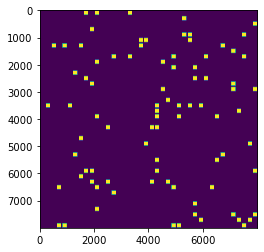

In [51]:
plt.imshow(im)

In [52]:
im

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
sigma = 400
im_blur = ndimage.gaussian_filter(cp.array(im), sigma, mode = 'constant')
#im_blur_norm = im_blur * sigma * cp.sqrt(cp.pi)
im_lap = ndimage.gaussian_laplace(cp.array(im), sigma=sigma)
im_sx = ndimage.sobel(im_blur, axis=1, mode='reflect')
im_sy = ndimage.sobel(im_blur, axis=0, mode='reflect')
im_sobel = cp.hypot(im_sx, im_sy)



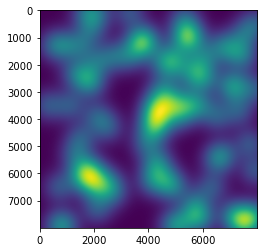

In [54]:
plt.imshow(im_blur.get())

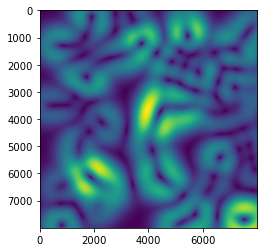

In [55]:
plt.imshow(im_sobel.get())

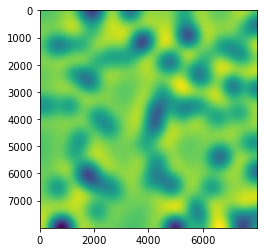

In [56]:
plt.imshow(im_lap.get())

# _____

# Feature Extraction

In [ ]:
scipy.ndima

In [3]:
cp.cuda.Device(1).use()

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000), dtype = np.float16)

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, np.array(centroids)

def get_filters(im, sigma):
    im_blur = ndimage.gaussian_filter(cp.array(im), sigma, mode = 'constant', cval=0.0)
    #im_blur_norm = im_blur * sigma * cp.sqrt(cp.pi)
    
    im_lap = ndimage.gaussian_laplace(cp.array(im), sigma=sigma)
    im_sx = ndimage.sobel(im_blur, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur, axis=0, mode='reflect')
    im_sobel = np.hypot(im_sx, im_sy)
    
    return im_blur, im_sobel, im_lap

def get_feats(centroids, im_blur, im_sobel, im_lap, org_radius):
    feats = []
    for x, y in centroids:
        x_min, x_max = x - org_radius, x + org_radius
        y_min, y_max = y - org_radius, y + org_radius

        density = cp.mean(im_blur[x_min: x_max, y_min: y_max])
        grad = cp.mean(im_sobel[y_min: y_max, y_min: y_max])
        lap = cp.mean(im_lap[y_min: y_max, y_min: y_max])

        feats.append((grad.get(), density.get(), lap.get()))

    return np.vstack(feats)
    

# generate global features for random

In [283]:
mempool = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()
pattern_dim = 40
threshold = 1/16
sigmas = [200, 400, 600, 800]
seeds = [3, 4, 7, 8, 11, 12]

seed_num = []
coords = []
random_feats = []
for seed in seeds:
    seed_sigmas = []
    im, centroids = generate_pattern(pattern_dim, threshold, seed)
    coords.append(centroids)
    seed_num.extend([seed]*len(centroids))
    for sigma in sigmas:
        im_gauss, im_sobel, im_lap = get_filters(im, sigma)
        feats = get_feats(centroids, im_gauss, im_sobel, im_lap, 75)
        seed_sigmas.append(feats)
    random_feats.append(np.hstack(seed_sigmas))

mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [284]:
len(seed_num)

568

In [285]:
seed_col = np.array(seed_num)

In [286]:
dfRandomFilter = pd.concat([pd.DataFrame(seed_col), pd.DataFrame(np.vstack(coords)), pd.DataFrame(np.vstack(random_feats))], axis = 1)

In [287]:
dfRandomFilter.shape

(568, 15)

In [288]:
columns = ['seed','design_x', 'design_y', 'grad200', 'density200', 'lap200', 'grad400', 'density400', 'lap400', 'grad600', 'density600', 'lap600', 'grad800', 'density800', 'lap800']

In [289]:
dfRandomFilter.columns = columns

In [290]:
random2 = pd.read_csv("random_features_dipole_v2.csv")

In [291]:
dfRandomFilter.shape, random2.shape

((568, 15), (568, 16))

In [292]:
np.all(dfRandomFilter.iloc[:, :2] == random2.iloc[:, :2])

True

In [293]:
dfRandomFilter["dipole"] = random2.dipole

In [294]:
dfRandomFilter.head()

,seed,design_x,design_y,grad200,density200,lap200,grad400,density400,lap400,grad600,density600,lap600,grad800,density800,lap800,dipole
0,3,100,1700,49.580061,40.610482,2.647986e-04,17.485817,20.319155,0.000018,11.066276,13.188181,-0.000006,7.683752,10.507616,-0.000005,0.009339
1,3,100,2100,153.904971,40.610482,-2.115952e-04,42.225697,20.388492,-0.000021,29.440110,13.446663,-0.000013,23.171850,10.885945,-0.000005,0.030979
2,3,100,3300,0.000000,34.929492,-5.303500e-08,20.098803,11.975499,0.000024,49.324703,8.866869,0.000022,45.624253,9.037774,0.000010,0.055079
3,3,300,5300,0.000000,22.667091,-5.303500e-08,13.713141,12.745831,0.000021,31.708185,10.321576,0.000022,29.480326,9.570419,0.000010,0.023477
4,3,500,7900,241.065425,35.521567,1.000357e-03,40.129407,15.331199,-0.000074,50.824859,11.324184,-0.000077,32.121419,9.957979,-0.000037,0.000000


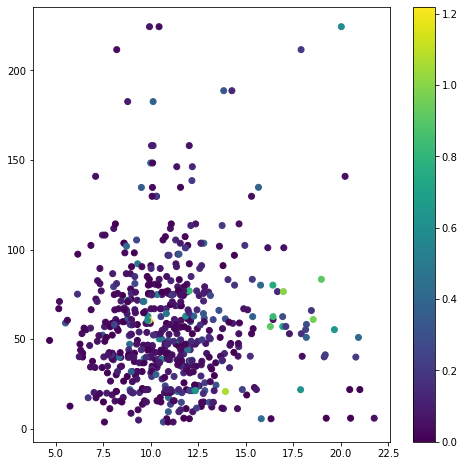

In [295]:
plt.scatter(dfRandomFilter.density800.values, dfRandomFilter.grad400.values, c = dfRandomFilter.dipole.values)
plt.colorbar()

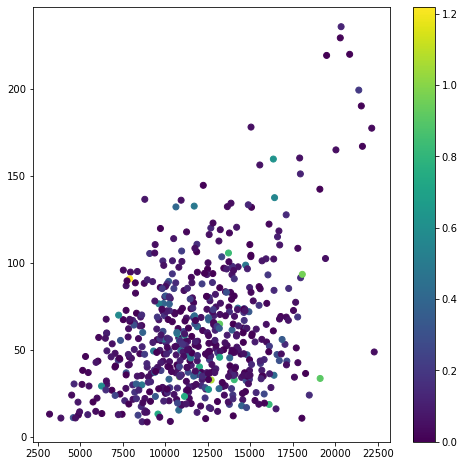

In [296]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
plt.scatter(dfHeitorRandom.density_800.values, dfHeitorRandom.grad_400.values, c = dfRandomFilter.dipole.values)
plt.colorbar()

In [196]:
dfRandomFilter.to_csv("dfRandomFilter.csv", index=False)

# generate global features for paired

In [2]:
b1 = np.ones((13,17))
b2 = np.ones((12,17))
res1_lo = np.argwhere(b1 == 1)
res2_lo = np.argwhere(b2 == 1)
res1_empty = np.array(
    [0,1,2,15,16,17,
     17*2-1,17*3-1,17*4-1,17*5-1,17*6-1,
     17*6,17*7-1,17*7,17*7+2,17*8-1,
     17*8,17*8+1,17*9,17*9+1,17*9+11,
     17*10,17*10+1,17*11,17*11+1,17*11+7,17*11+9,
     17*12-1,17*12,17*12+1,17*12+2,17*12+3,17*12+5,
     17*12+6,17*12+7,17*12+8,17*12+9,17*12+10,17*12+11,
     17*12+12,17*12+13,17*12+14,17*12+15,17*12+16])
res2_empty = np.array(
    [0,1,14,15,16,17,
     17*2-1,17*3-1,17*4-1,17*5-1,17*6-1,
     17*6,17*6+4,17*7-1,17*7,17*8-1,
     17*8,17*8+1,17*8+2,17*9,17*9+1,17*9+2,
     17*10,17*10+1,17*10+5,17*11-1,17*11,
     17*11+2,17*11+14,17*11+15])

res1_lo = np.delete(res1_lo, res1_empty, axis=0)
res2_lo = np.delete(res2_lo, res2_empty, axis=0)

res1 = np.array([np.array([yi*850, xi*600])+500 for yi, xi in res1_lo])
res2 = np.array([np.array([yi*850, xi*600])+500 for yi, xi in res2_lo])

centroids = []
im = np.zeros((11000, 11000), dtype= np.float64)
for k in range(res1.shape[0]):
    y, x = res1[k][0], res1[k][1]
    im[y:y+200,x:x+200] = 255
    centroids.append((y+100, x+100))
for k in range(res2.shape[0]):
    y, x = res2[k][0], res2[k][1]
    im[y+250:y+450,x:x+200] = 255
    centroids.append((y+250+100, x+100))

In [18]:
def extract_features(im, sigma):
    im_8=np.uint8(im)
    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


    im_blur = ndimage.gaussian_filter(cp.array(im), sigma=sigma, mode='constant',cval=0)
    im_blur_norm=im_blur*sigma*np.sqrt(np.pi)
    im_sx = ndimage.sobel(im_blur, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
    
    feats = []
    #im_lap = ndimage.gaussian_laplace(im, sigma=sigma, mode='reflect')
    for jj in range(np.shape(contours)[0]):            
        im_zer = np.zeros( (im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)
        #number_mat[ii,jj]=number

        density=cp.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad=cp.nanmean(im_sobel[obj[:,0],obj[:,1]])

        #lap=np.nanmean(im_lap[obj[:,0],obj[:,1]])


        feats.append([grad.get(), density.get()])

    return np.array(feats)

In [19]:
hi = extract_features(im, 20)

KeyboardInterrupt: 

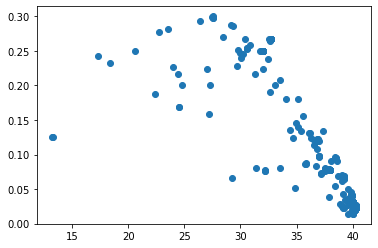

In [16]:
plt.scatter(hi[:, 1], hi[:, 0])
#plt.gca().invert_yaxis()

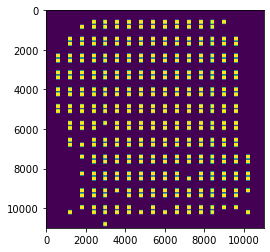

In [11]:
plt.imshow(im)

In [12]:
len(centroids)

351

In [13]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
sigmas = [400]#200, 400, 600, 800

paired_feats = []
for sigma in sigmas:
    im_gauss, im_sobel, im_lap = get_filters(im, sigma)
    feats = get_feats(centroids, im_gauss, im_sobel, im_lap, 100)
    paired_feats.append(feats)
    
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [14]:
paired_feats = np.hstack(paired_feats)

In [15]:
dfPairedFilter = pd.concat([pd.DataFrame(centroids), pd.DataFrame(paired_feats)], axis = 1)

In [16]:
columns400 = ['design_x', 'design_y','grad400', 'density400', 'lap400']

In [41]:
columns = ['design_x', 'design_y', 'grad200', 'density200', 'lap200', 'grad400', 'density400', 'lap400', 'grad600', 'density600', 'lap600', 'grad800', 'density800', 'lap800']

In [17]:
dfPairedFilter.columns = columns400

In [18]:
dfPairedFilter.head(100)

,design_x,design_y,grad400,density400,lap400
0,600,2400,0.012208,29.188935,-0.000029
1,600,3000,0.026659,32.604708,0.000011
2,600,3600,0.020084,32.734117,0.000019
3,600,4200,0.016522,32.734117,-0.000025
4,600,4800,0.028702,32.734117,-0.000009
...,...,...,...,...,...
95,5700,3600,0.020084,37.568702,0.000019
96,5700,4200,0.016522,40.204473,-0.000025
97,5700,4800,0.028702,40.311766,-0.000009
98,5700,5400,0.011618,40.311766,0.000026


In [19]:
dfHeitorPaired = pd.read_csv("paired_features_dipole_v2.csv")

dfHeitorPaired.iloc[:, :2].shape, dfPairedFilter.iloc[:, :2].shape

np.all(dfHeitorPaired.iloc[:, :2] == dfPairedFilter.iloc[:, :2])

True

In [20]:
dfPairedFilter["dipole"] = dfHeitorPaired.dipole

dfPairedFilter.head()

,design_x,design_y,grad400,density400,lap400,dipole
0,600,2400,0.012208,29.188935,-0.000029,2.545256
1,600,3000,0.026659,32.604708,0.000011,1.929029
2,600,3600,0.020084,32.734117,0.000019,3.102732
3,600,4200,0.016522,32.734117,-0.000025,2.438344
4,600,4800,0.028702,32.734117,-0.000009,3.279811


In [21]:
dfPairedFilter.to_csv("dfPairedFilter.csv", index=False)

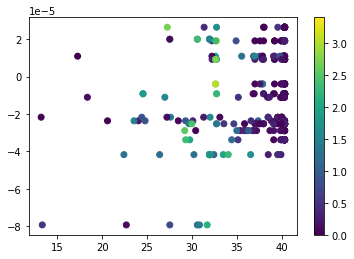

In [22]:
plt.scatter(dfPairedFilter.density400.values, dfPairedFilter.lap400.values, c = dfPairedFilter.dipole.values)
plt.colorbar()

In [310]:
dfhpo = pd.read_csv("paired_features_dipole.csv")

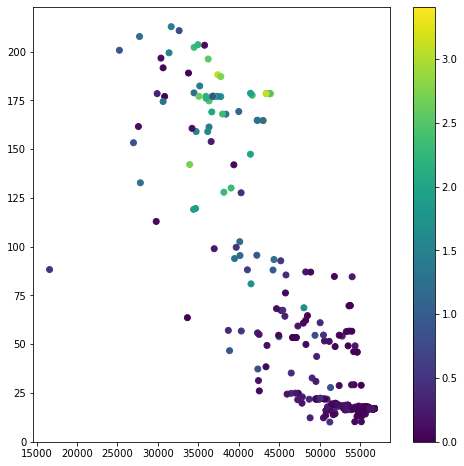

In [311]:
plt.scatter(dfhpo.density_800.values, dfhpo.grad_400.values, c = dfhpo.dipole.values)
plt.colorbar()

# Filters Combined

In [57]:
dfFilterCombined = pd.concat([dfRandomFilter, dfPairedFilter], axis = 0)

In [58]:
dfFilterCombined.shape

(919, 14)

In [59]:
dfFilterCombined.head()

,design_x,design_y,grad200,density200,lap200,grad400,density400,lap400,grad600,density600,lap600,grad800,density800,lap800
0,100,1700,9.491111,23.898844,8.179600,10.291289,10.249867,12.777956,0.000000,6.032844,0.000000,0.000000,4.629778,0.000000
1,100,2100,31.898711,23.898844,17.658889,6.949111,10.268311,5.119956,1.188667,6.075911,0.910222,6.417289,4.946311,4.130133
2,100,3300,0.000000,20.318400,0.000000,0.045467,5.406533,0.364356,1.426889,4.000000,3.151689,1.775822,4.000000,2.639511
3,300,5300,0.000000,21.065956,0.000000,0.000000,9.315822,0.000000,3.366844,6.529378,2.560000,0.000000,5.480000,0.000000
4,500,7900,47.858267,20.988400,31.049867,17.197822,7.325422,9.523200,6.238222,4.325911,3.310933,4.247067,3.070089,2.252800


In [60]:
dfFilterCombined.to_csv("dfFilterCombined.csv", index = False)

In [ ]:
x, y, z = hi.density800.values, hi.grad400.values, 

# feature selection

Methods:
- Preprocessing
    - F statistic
    - Correlation matrix
- Linear
    - Lasso
    - Kitchen sink LASSO
    - LASSO with AIC and BIC, forward and backward
    - F statistic
- Non Linear
    - Mutual info reg
    - Random forest feature importance

In [4]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")

rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]

In [5]:
dfHeitorPaired = pd.read_csv("paired_features_dipole.csv")

In [7]:
pX, py = dfHeitorPaired.iloc[:, :-1], dfHeitorPaired.iloc[:, -1]

In [83]:
dfHeitorPaired.head()

,density_200,density_400,density_600,density_800,grad_200,grad_400,grad_600,grad_800,dipole
0,14775.063251,17208.263161,24877.549625,33637.699448,195.354097,63.532221,61.858934,49.945970,0.007636
1,12417.993146,9464.479680,11601.077148,16608.465085,164.970190,88.222864,117.955345,126.356989,0.528102
2,19143.832469,20788.735211,26641.291190,34462.961503,328.264800,202.209346,202.996991,174.854846,2.338594
3,19400.492713,23131.114613,29561.557122,37394.875098,320.059488,188.151840,191.717735,160.836264,3.068889
4,19400.492713,23146.182555,29668.873971,37764.489954,320.059488,187.207048,187.440958,154.595113,2.755386


### find most important features in random

#### Heitor

In [86]:
# linear

from sklearn.feature_selection import f_regression
f_regression(rX, ry)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2).fit(rX)
poly.get_feature_names(rX.columns)
rXpoly = poly.transform(rX)
f_regression(rXpoly, ry)

# lasso

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rXscaled = scaler.fit_transform(rX)
regr = linear_model.Lasso(alpha=0.1)
regr.fit(rX, ry)
np.around(regr.coef_, 4)

# kitchen sink lasso



poly = PolynomialFeatures(2).fit(rX)
poly.get_feature_names(rX.columns)
rXpoly = poly.transform(rX)
regr = linear_model.Lasso(alpha=0.1, max_iter=10000, normalize=True, tol=1e-3)
regr.fit(rXpoly, ry)
regr.coef_

# mutual info

from sklearn.feature_selection import mutual_info_regression

mutual_info_regression(rX, ry)

mutual_info_regression(rXpoly, ry)

# random forest feature selection

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=2)
forest.fit(rX, ry)
forest.feature_importances_

# permutation importance with random forest

from sklearn.inspection import permutation_importance

result = permutation_importance(forest, rX, ry, n_repeats=10)
result.importances_mean, result.importances_std


### find most important features in paired

#### Heitor

In [163]:
f_regression(pX, py)

pd.DataFrame(f_regression(pX, py)[1].reshape(1,-1))

regr = linear_model.Lasso(alpha=0.1)
regr.fit(pX, py)
np.around(regr.coef_, 4)

pd.DataFrame(regr.coef_.reshape(1,-1))

mutual_info_regression(pX, py)

pd.DataFrame(mutual_info_regression(pX, py).reshape(1,-1))

forest = RandomForestRegressor(max_depth=2)
forest.fit(pX, py)
forest.feature_importances_

pd.DataFrame(forest.feature_importances_).T

result = permutation_importance(forest, pX, py, n_repeats=10)
result.importances_mean, result.importances_std

pd.DataFrame(np.array([0.00695526, 0.00489972, 0.06856511, 0.07010185, 0.00269882,
        0.83189961, 0.01702779, 0.00862741])).T

(array([ 10.83373913, 190.57712049, 259.22533309, 233.85311347,
          1.74918325, 530.11002228, 332.66022276, 187.51226661]),
 array([1.09877882e-03, 7.10957555e-35, 5.57100410e-44, 9.64294082e-41,
        1.86847939e-01, 6.26459539e-72, 1.23003773e-52, 1.92905145e-34]))

### find most important features in combined

#### Heitor

In [8]:
bX = pd.concat([rX, pX], axis = 0)

by = pd.concat([ry, py], axis = 0)

bX.to_csv("dfXFilterHeitor.csv", index=False)

by.to_csv("dfyFilterHeitor.csv", index=False)

In [10]:
x, y , z = bX.density_800, bX.grad_400, by

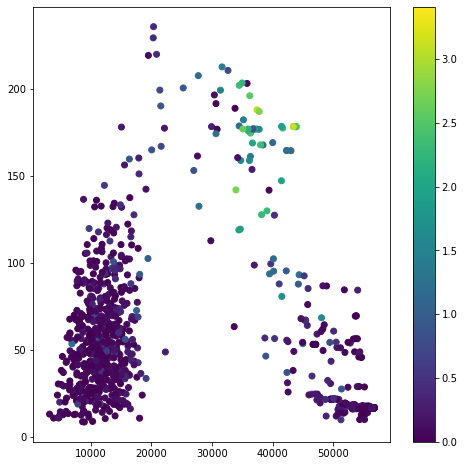

In [16]:
plt.scatter(x,y, c = z)
plt.colorbar()

In [8]:


f_regression(bX, by)

pd.DataFrame(f_regression(bX, by)[1].reshape(1,-1))

regr = linear_model.Lasso(alpha=0.1)
regr.fit(bX, by)
pd.DataFrame(regr.coef_.reshape(1,-1))

pd.DataFrame(mutual_info_regression(bX, by)).T

forest = RandomForestRegressor(max_depth=2)
forest.fit(bX, by)
pd.DataFrame(forest.feature_importances_).T

result = permutation_importance(forest, bX, by, n_repeats=10)
pd.DataFrame(result.importances_mean).T

# predict with different models

Datasets
- Density 800 and grad 600
- All the data
- Density 600 and grad 600
- Grad 400 and grad 600

Models
- Linear Regression
- SVM
- Random forest with mse and mae
- Boosted regression tree
- Gaussian Processes

## Density 800 and Grad 600

In [18]:
bXsub = bX[["density_800", "grad_400"]]

#### linear regression

In [88]:

regr = linear_model.LinearRegression()
scores = cross_val_score(regr, bXsub, by, cv=5, scoring="neg_mean_squared_error")

scores.mean()

regr = linear_model.LinearRegression()
scores = cross_val_score(regr, bXsub, by, cv=5, scoring="neg_mean_absolute_error")

scores.mean()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bXsubScale = scaler.fit_transform(bXsub)

regr = linear_model.LinearRegression()
scores = cross_val_score(regr, bXsubScale, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

regr = linear_model.LinearRegression()
scores = cross_val_score(regr, bXsubScale, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

#### SVM

In [101]:

svr = SVR()
scores = cross_val_score(svr, bXsub, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

svr = SVR()
scores = cross_val_score(svr, bXsubScale, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

svr = SVR()
scores = cross_val_score(svr, bXsub, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

svr = SVR()
scores = cross_val_score(svr, bXsubScale, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

svr.fit(bXsubScale, by)

#### random forest with MSE and MAE

In [80]:


forest = RandomForestRegressor(max_depth=2)
scores = cross_val_score(forest, bXsub, by, cv=5, scoring="neg_mean_squared_error")

np.mean(scores)



forest = RandomForestRegressor(max_depth=2)
scores = cross_val_score(forest, bXsub, by, cv=5, scoring="neg_mean_absolute_error")

scores.mean()

#### boosted regression trees with MSE and MAE

In [120]:

boost = GradientBoostingRegressor()
scores = cross_val_score(boost, bXsub, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

boost = GradientBoostingRegressor()
scores = cross_val_score(boost, bXsubScale, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

from sklearn.ensemble import GradientBoostingRegressor

boost = GradientBoostingRegressor()
scores = cross_val_score(boost, bXsub, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

from sklearn.ensemble import GradientBoostingRegressor

boost = GradientBoostingRegressor()
scores = cross_val_score(boost, bXsubScale, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

-0.1461626606556518

#### gaussian processes

In [129]:


kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel)
scores = cross_val_score(gp, bXsubScale, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel)
scores = cross_val_score(gp, bXsubScale, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

kernel = DotProduct()
gp = GaussianProcessRegressor(kernel=kernel)
scores = cross_val_score(gp, bXsubScale, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

kernel = DotProduct()
gp = GaussianProcessRegressor(kernel=kernel)
scores = cross_val_score(gp, bXsubScale, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

kernel = WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel)
scores = cross_val_score(gp, bXsubScale, by, cv=5, scoring="neg_mean_squared_error")
scores.mean()

-0.13600877667646

## All predictors

In [13]:
# svm

In [17]:
scaler = StandardScaler()
bXScale = scaler.fit_transform(bX)
svr = SVR()
scores = cross_val_score(svr, bXScale, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

-0.16459317984756786

In [105]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.title("Feature Importance SVR with Linear Kernel")
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

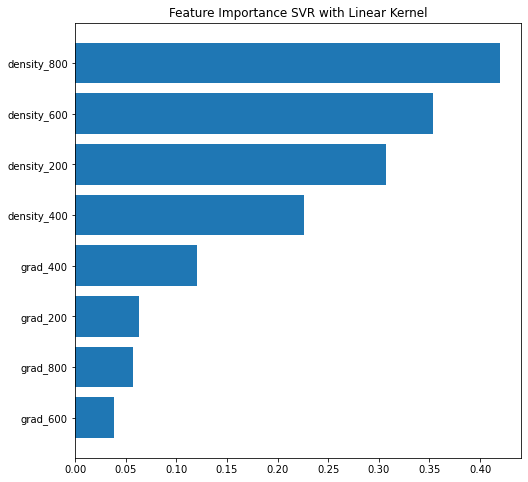

In [107]:
svr = SVR(kernel="linear")
svr.fit(bXScale, by)
f_importances(np.abs(svr.coef_[0]), bX.columns.to_list())

In [31]:
pd.DataFrame(svr.coef_[0]).T

,0,1,2,3,4,5,6,7
0,0.306712,-0.226132,-0.353429,0.419869,-0.06342,0.120597,0.037993,0.057277


In [111]:
hi = bX[["density_800", "grad_400"]]

In [112]:
pd.DataFrame(hi).corr()

,density_800,grad_400
density_800,1.000000,-0.189872
grad_400,-0.189872,1.000000


In [113]:
scaler = StandardScaler()
hiScale = scaler.fit_transform(hi)
svr = SVR(epsilon=0.1)
scores = cross_val_score(svr, hiScale, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

-0.1643237429562606

In [55]:
forest = RandomForestRegressor(max_depth=2)
scores = cross_val_score(forest, bX, by, cv=5, scoring="neg_mean_absolute_error")
scores.mean()

-0.18455437165456146

In [57]:
forest = RandomForestRegressor(max_depth=2)
forest.fit(bX,by)
forest.feature_importances_

array([0.00499965, 0.0031167 , 0.00255077, 0.0550962 , 0.04229479,
       0.03171957, 0.8509248 , 0.00929751])

# Comparing Datasets

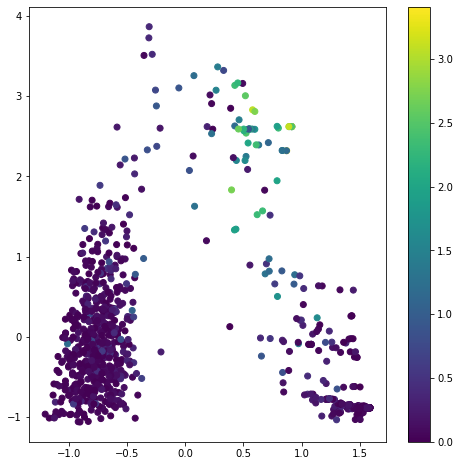

In [132]:
bX = pd.read_csv("dfXFilterHeitor.csv")

by = pd.read_csv("dfyFilterHeitor.csv").values

bxSub = bX[["density_800", "grad_400"]]
scaler = StandardScaler()
bxSubScale = scaler.fit_transform(bxSub)

x, y, z = bxSubScale[:, 0], bxSubScale[:, 1], by
plt.scatter(x,y, c = z)
plt.colorbar()

In [98]:
svr = SVR(epsilon=0.1)
scores = cross_val_score(svr, bxSubScale, by.ravel(), cv=5, scoring="neg_mean_absolute_error")
scores.mean()

-0.16432374295626057

In [134]:
random2 = pd.read_csv("random_features_dipole_v2.csv")

paired2 = pd.read_csv("paired_features_dipole_v2.csv")

bx2 = pd.concat([random2, paired2], axis = 0)

In [136]:
bx2.shape

(919, 16)

In [140]:
bx2.head()

,seed,design_x,design_y,grad200,density200,lap200,grad400,density400,lap400,grad600,density600,lap600,grad800,density800,lap800,dipole
0,3.0,100.0,1700.0,9.491111,23.898844,8.179600,10.291289,10.249867,12.777956,0.000000,6.032844,0.000000,0.000000,4.629778,0.000000,0.009339
1,3.0,100.0,2100.0,31.898711,23.898844,17.658889,6.949111,10.268311,5.119956,1.188667,6.075911,0.910222,6.417289,4.946311,4.130133,0.030979
2,3.0,100.0,3300.0,0.000000,20.318400,0.000000,0.045467,5.406533,0.364356,1.426889,4.000000,3.151689,1.775822,4.000000,2.639511,0.055079
3,3.0,300.0,5300.0,0.000000,21.065956,0.000000,0.000000,9.315822,0.000000,3.366844,6.529378,2.560000,0.000000,5.480000,0.000000,0.023477
4,3.0,500.0,7900.0,47.858267,20.988400,31.049867,17.197822,7.325422,9.523200,6.238222,4.325911,3.310933,4.247067,3.070089,2.252800,0.000000


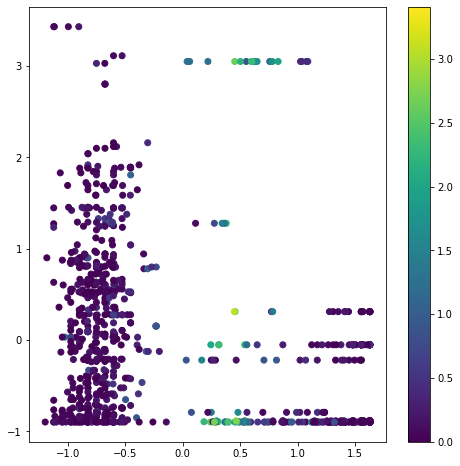

In [142]:
bx2Sub = bx2[["density800", "lap400"]]
scaler = StandardScaler()
bxSubScale = scaler.fit_transform(bx2Sub)

x, y, z = bx2SubScale[:, 0], bx2SubScale[:, 1], bx2.dipole.values
plt.scatter(x,y, c = z)
plt.colorbar()